In [124]:
import os
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
from scipy.ndimage import generate_binary_structure, label
from scipy.ndimage import sum as ndimage_sum

from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder

f_name = "./ref_FS001_121011_1_J.fits"
#f_name = "./ref_FS014_151219_1_J.fits"
#f_name = "./ref_FS017_120106_1_J.fits"

# satelita

def add_satellite(img, length=50, width=3, flux=10000, sigma=2.0):
    nx,ny = img.shape
    x0 = np.random.randint(0, nx)
    y0 = np.random.randint(0, ny)
    angle = np.random.uniform(0, np.pi)

    x = np.arange(nx)
    y = np.arange(ny)
    Y, X = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')

    # Linie proste w kierunku angle
    dx = np.cos(angle)
    dy = np.sin(angle)

    # Wyznacz odległość punktów od linii satelity
    dist = ( (X - x0)*dy - (Y - y0)*dx )  # równoległe
    along = ( (X - x0)*dx + (Y - y0)*dy )  # wzdłuż

    # maska: pas o długości `length`, szerokości `width`
    mask = (np.abs(dist) < width) & (np.abs(along) < length / 2)

    temp = np.zeros_like(img, dtype=float)
    temp[mask] = flux

    return img + gaussian_filter(temp, sigma=sigma)


# cosmic ray

def add_cosmic_ray(img, n_segments=1, flux=30000, thickness=1):
    nx,ny = img.shape
    temp = np.zeros_like(img, dtype=float)
    x,y = np.random.randint(10, nx - 10), np.random.randint(10, ny - 10)

    for _ in range(n_segments):
        dx = np.random.randint(-5, 6)
        dy = np.random.randint(-5, 6)
        x_new = np.clip(x + dx, 0, nx - 1)
        y_new = np.clip(y + dy, 0, ny - 1)

        # Prostokąt o grubości `thickness`
        for i in range(-thickness, thickness + 1):
            for j in range(-thickness, thickness + 1):
                xi = np.clip(int(x_new + i), 0, nx - 1)
                yi = np.clip(int(y_new + j), 0, ny - 1)
                temp[yi, xi] += flux

        x, y = x_new, y_new

    return img + temp


In [125]:
hdul = fits.open(f_name)
image = hdul[0].data
header = hdul[0].header
hdul.close()


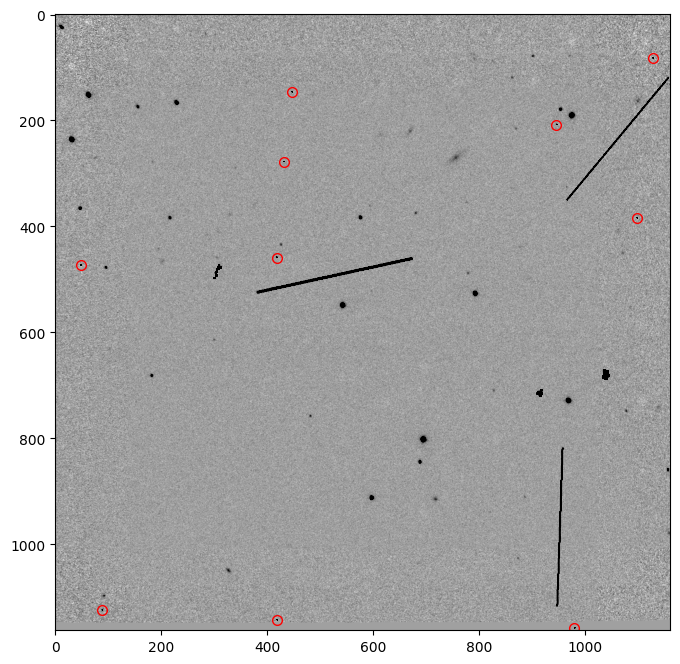

In [126]:
# dodanie hot pikseli

np.random.seed(12)

hot_piksels = Table(names=('x', 'y', 'flux'), dtype=(int, int, float))

flux = 5000
for _ in range(10):
    x = np.random.randint(0, image.shape[0])
    y = np.random.randint(0, image.shape[1])
    hot_piksels.add_row((x, y, flux))
    image[y,x] = image[y,x] + flux

# satelita

np.random.seed(1)
image = add_satellite(image, length=300, width=1, flux=100, sigma=0.5)
image = add_cosmic_ray(image, n_segments=10, flux=500, thickness=1)

np.random.seed(2)
image = add_satellite(image, length=300, width=2, flux=100, sigma=0.5)
image = add_cosmic_ray(image, n_segments=10, flux=500, thickness=1)

np.random.seed(3)
image = add_satellite(image, length=300, width=1, flux=100, sigma=0.5)
image = add_cosmic_ray(image, n_segments=10, flux=500, thickness=2)

# rysowanie

x_hot = hot_piksels["x"].data
y_hot = hot_piksels["y"].data

vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)

plt.figure(figsize=(8, 8))
plt.imshow(image,vmin=vmin+5,vmax=vmax+5,cmap='binary')
plt.plot(x_hot, y_hot, 'o', markerfacecolor='none', markeredgecolor='red', markersize=7)
plt.show()

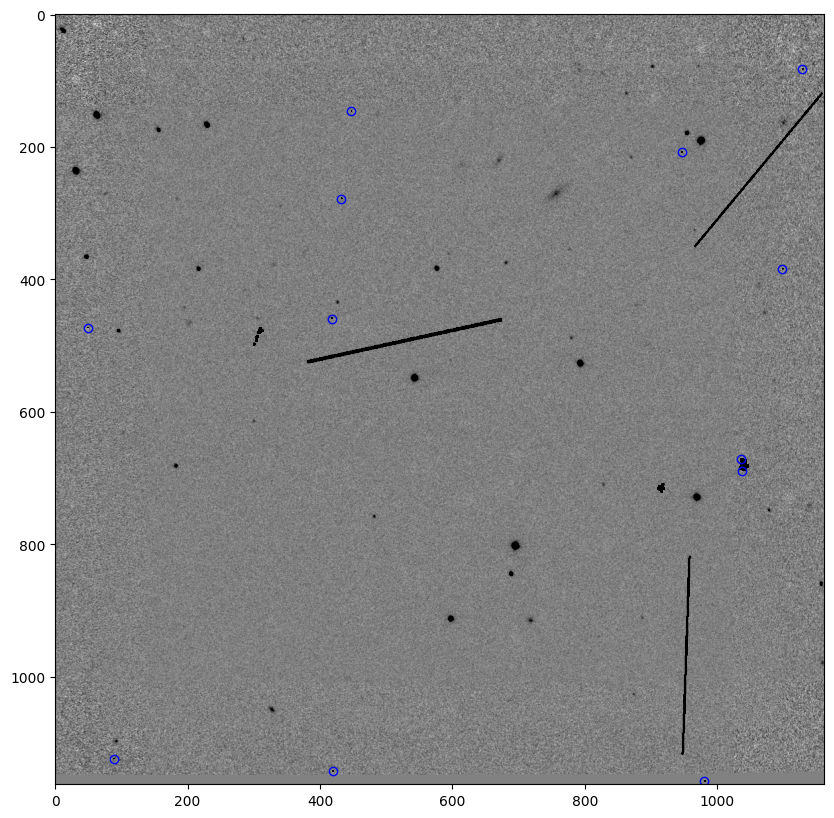

In [127]:
# filtr 


kernel1 = [[0,-1,0],
          [-1,4,-1],
          [0,-1,0]]

kernel2 = [[0,-1,0],
          [-1,0,1],
          [0,1,0]]


result = convolve(image, kernel1)

maska = result > np.median(result) + 500 #+ 5 * mad_std(result)

# znajdowanie grup

conection_kernel = generate_binary_structure(2, 2) # kernel grupowania
labeled_array, num_features = label(maska, structure=conection_kernel)
sizes = ndimage_sum(maska, labeled_array, range(1, num_features + 1))


crays_x = []
crays_y = []

hot_x = []
hot_y = []

for i in range(1, num_features + 1):
    tmp = np.argwhere(labeled_array == i)
    if len(tmp) == 1:
        ax,ay = tmp[0]
        d = 5
        image_cut = image[ax-d:ax+d,ay-d:ay+d]
        mk = image_cut > np.median(image_cut) + 1000 #+ 100 * mad_std(image_cut)
        if len(image_cut[mk]) == 1:
            hot_x.append(ay)
            hot_y.append(ax)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)
ax.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
#ax.plot(crays_x,crays_y,"r.")
#X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
#countours = ax.contour(X, Y, maska, 0, colors='red', linewidths=1) ##linewidth parameter had to be adjusted by eye estimation.

ax.plot(hot_x,hot_y,"ob",mfc='none')

plt.show()



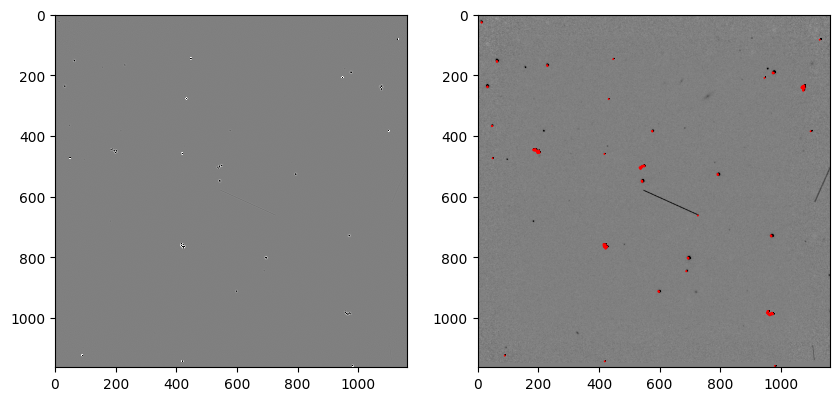

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

vmin = np.mean(result) - 1 * np.std(result)
vmax = np.mean(result) + 1 * np.std(result) 
ax[0].imshow(result,vmin=vmin,vmax=vmax,cmap='binary')


vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)
ax[1].imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
countours = ax[1].contour(X, Y, maska, 0, colors='red', linewidths=1) ##linewidth parameter had to be adjusted by eye estimation.


plt.show()